# Danial Azimi 

In [146]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from tqdm import tqdm
from nltk import ngrams
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Importing data

In [147]:
train_essays_df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")

In [148]:
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [149]:
train_essays_df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

### Dataset is highly imbalance!

#### I will use this additional dataset to balance the dataset for training my models!

In [150]:
added_train_df= pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [151]:
added_train_df.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [152]:
added_train_df.rename(columns={'label': 'generated'}, inplace=True)
added_train_df['generated'].value_counts()

generated
0    27371
1    17497
Name: count, dtype: int64

In [153]:
added_train_df.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


## Data Cleaning

#### Removing the duplicates and Null values for both of the datasets

In [154]:
train_essays_df = train_essays_df.drop_duplicates('text')
train_essays_df = train_essays_df.dropna(subset=['text'])

In [155]:
added_train_df = added_train_df.drop_duplicates('text')
added_train_df = added_train_df.dropna(subset=['text'])

## Sampling

#### Before merging these two datasets, we need to sample the added dataset to create a balance between the values in the generated column, as there are 1372 more data points in the original dataframe, the number of samples for genarated column with 1 as its values, are as much more.

In [156]:
random_ai_generated = added_train_df[added_train_df['generated'] == 1].sample(n=11372, random_state=42)    
random_human_generated = added_train_df[added_train_df['generated'] == 0].sample(n=10000, random_state=42) 

## Concating 

#### Here we concat our datasets using their mutual columns, which are the ones that we actually wanna use! (text and genarated)

In [157]:
train_essay_selected = train_essays_df[['text', 'generated']]
df_train = pd.concat([train_essay_selected, random_ai_generated[['text', 'generated']],random_human_generated[['text', 'generated']]])   
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [158]:
df = df_train
class_distribution = df['generated'].value_counts()
print("Class Distribution:\n", class_distribution)

Class Distribution:
 generated
1    11375
0    11375
Name: count, dtype: int64


### Here you are! a balanced dataset!

# EDA and Feature Engineering

# Text Length based Analysis

### these are some contemporary features added for better visualization, thus understanding of data!

In [159]:
# Get tokens
tqdm.pandas(desc="Tokenizing Text")
df['tokens'] = df['text'].progress_apply(lambda x: word_tokenize(str(x)))
df['characters'] = df['text'].progress_apply(lambda x: len(str(x)))
df['words'] = df['tokens'].progress_apply(lambda tokens: len(tokens))
df['unique_words'] = df['tokens'].progress_apply(lambda x: len(set(x)))
df['sentences'] = df['text'].progress_apply(lambda x: len(sent_tokenize(str(x))))

Tokenizing Text: 100%|██████████| 22750/22750 [00:21<00:00, 1040.32it/s]


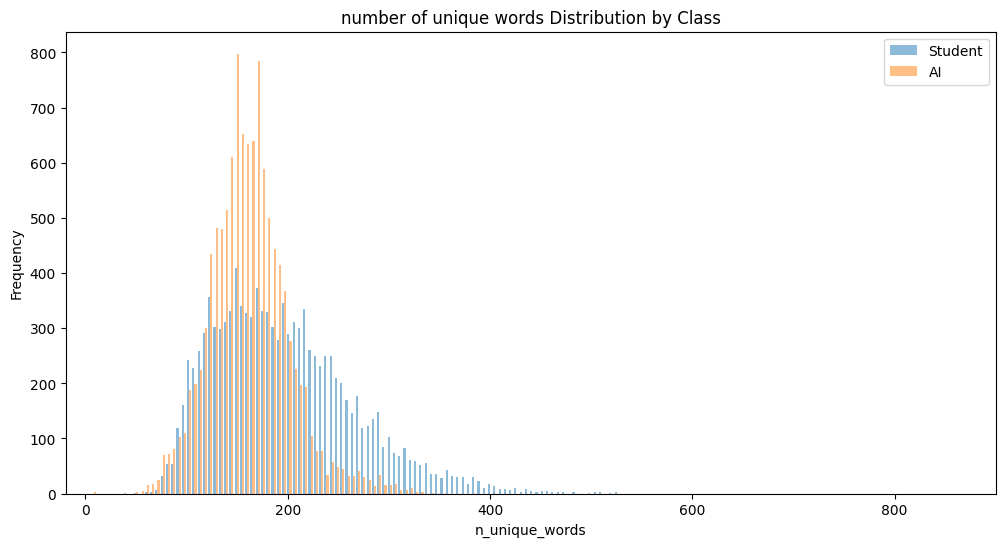

In [160]:
plt.figure(figsize=(12, 6))
plt.hist([df[df['generated'] == 0]['unique_words'], df[df['generated'] == 1]['unique_words']], bins=100, alpha=0.5, label=['Student', 'AI'])
plt.title('number of unique words Distribution by Class')
plt.xlabel('n_unique_words')
plt.ylabel('Frequency')
plt.xlim(right=900)
plt.legend()
plt.show()

## The difference between AI/Human generated text by number of unique words is really obvious!

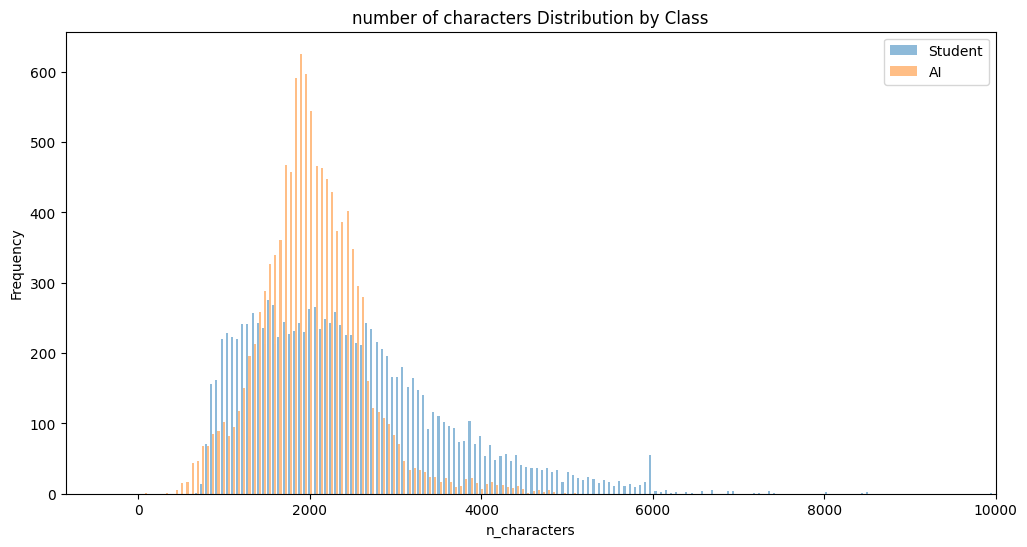

In [161]:
plt.figure(figsize=(12, 6))
plt.hist([df[df['generated'] == 0]['characters'], df[df['generated'] == 1]['characters']], bins=300, alpha=0.5, label=['Student', 'AI'])
plt.title('number of characters Distribution by Class')
plt.xlabel('n_characters')
plt.ylabel('Frequency')
plt.xlim(right=10000)
plt.legend()
plt.show()

### AI uses some characters more frequently and its distribution is more dense!

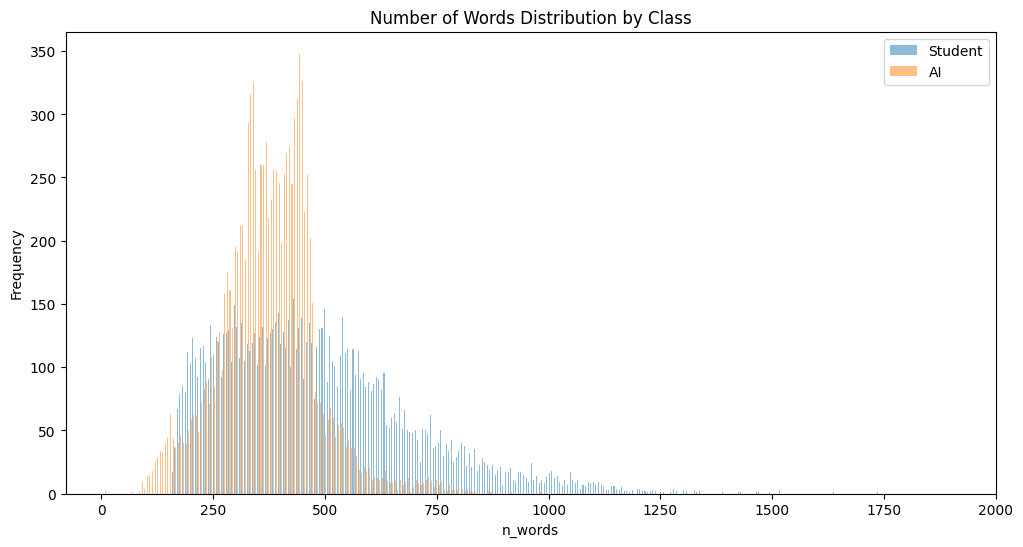

In [162]:
# Plot distribution of number of words
plt.figure(figsize=(12, 6))
plt.hist([df[df['generated'] == 0]['words'], df[df['generated'] == 1]['words']], bins=300, alpha=0.5, label=['Student', 'AI'])
plt.title('Number of Words Distribution by Class')
plt.xlabel('n_words')
plt.ylabel('Frequency')
plt.xlim(right=2000)
plt.legend()
plt.show()

### Same results as before, but this time by Number of Words!

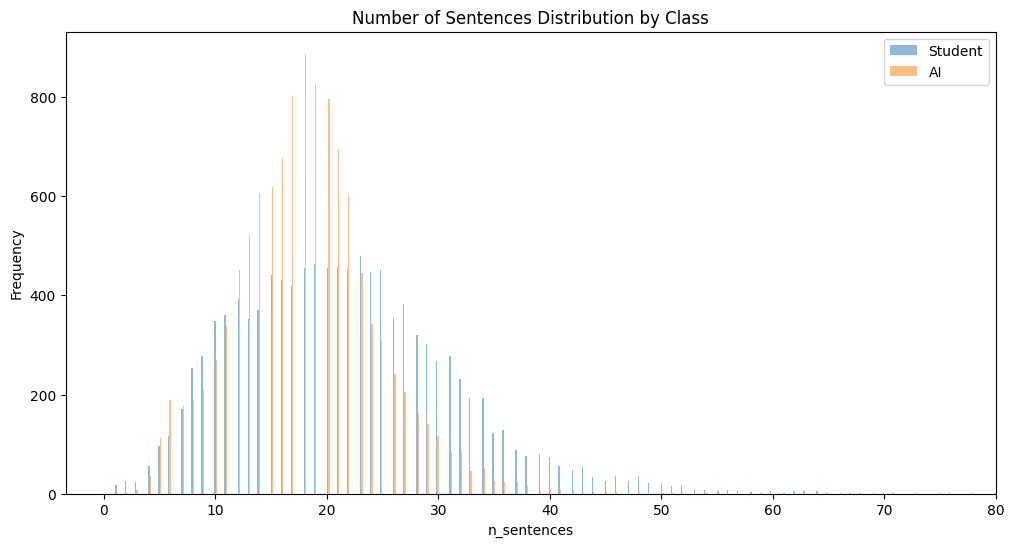

In [163]:
# Plot distribution of number of sentences
plt.figure(figsize=(12, 6))
plt.hist([df[df['generated'] == 0]['sentences'], df[df['generated'] == 1]['sentences']], bins=300, alpha=0.5, label=['Student', 'AI'])
plt.title('Number of Sentences Distribution by Class')
plt.xlabel('n_sentences')
plt.ylabel('Frequency')
plt.xlim(right=80)
plt.legend()
plt.show()

### Same pattern as before! AI uses less sentences with more frequency!

## 

## WordCloud

In [164]:
import gc
gc.collect()

205930

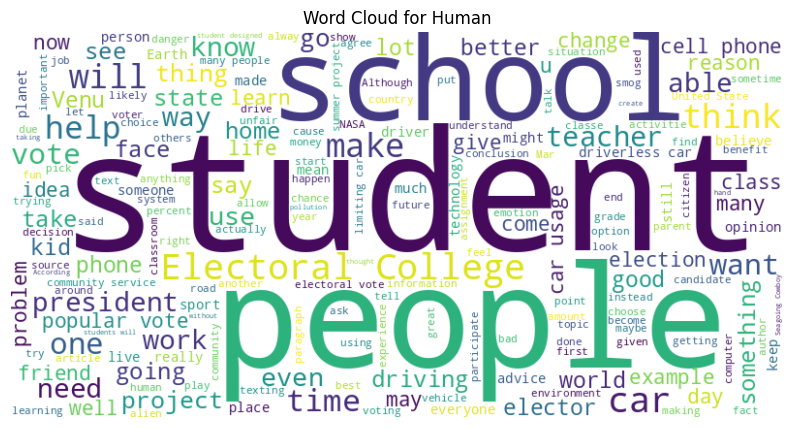

In [165]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['generated'] == 0]['text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Human')
plt.axis('off')
plt.show()

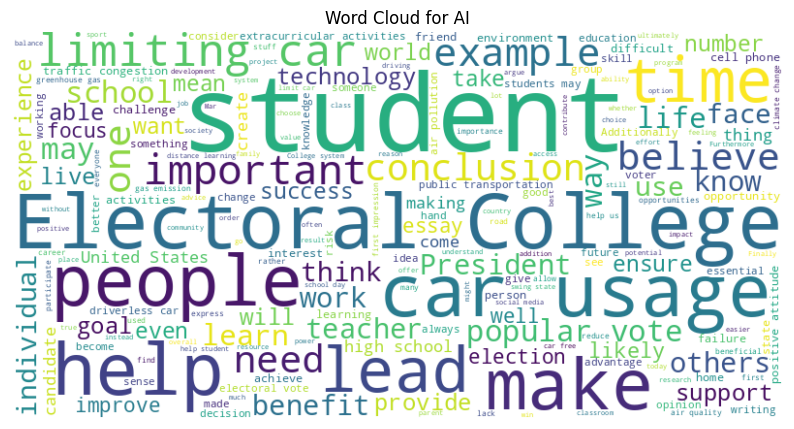

In [166]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['generated'] == 1]['text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for AI')
plt.axis('off')
plt.show()

### By cross-checking these two WordClouds, you can see the difference between them!

#### For example: the word "Electoral" is bolder in AI generated texts!

# n-Grams

### n-Grams could be used as an excellent tool for feature extraction, as well as being a great visualization tool!

In [167]:
# Extract n_grams
n_grams = [1,2,3]
for n in n_grams:
    df[f'{n}_grams'] = df['tokens'].progress_apply(lambda x: list(ngrams(x, n)))

Tokenizing Text: 100%|██████████| 22750/22750 [00:03<00:00, 6414.66it/s]


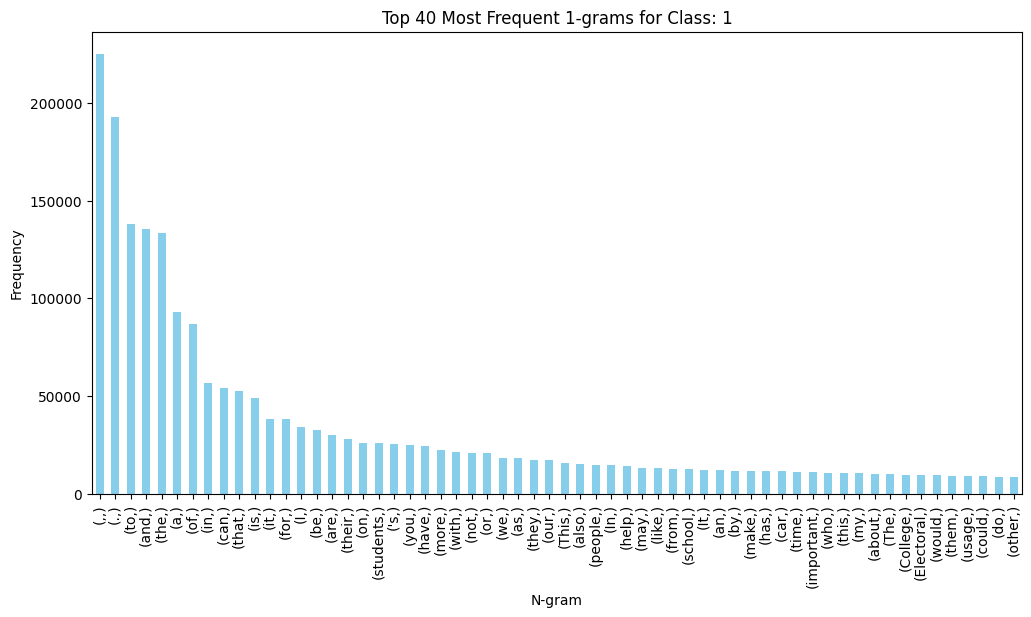

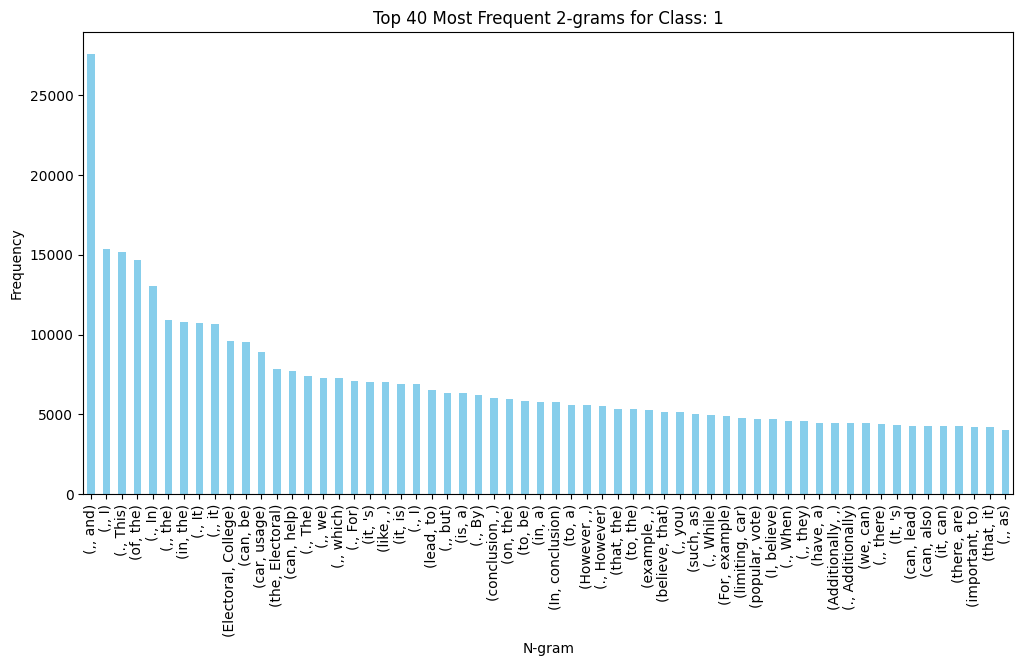

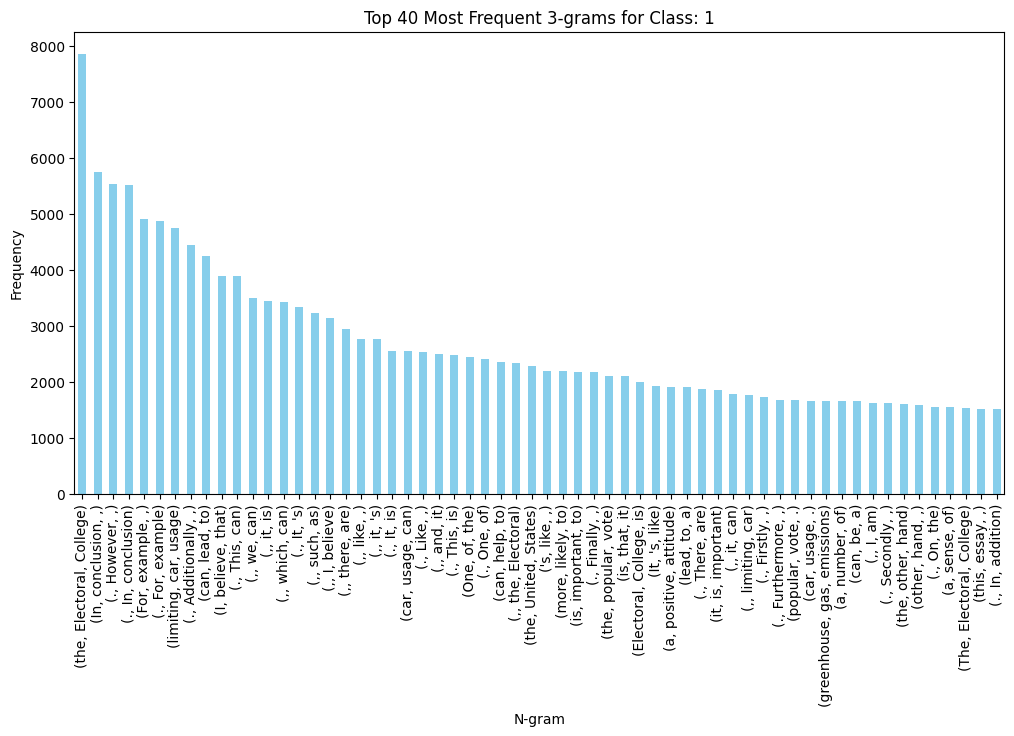

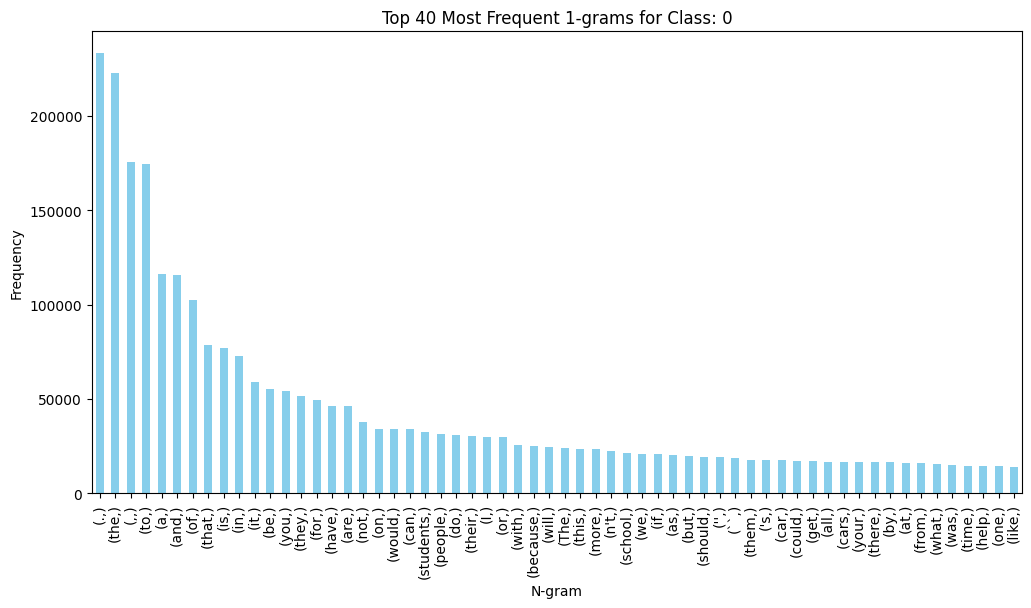

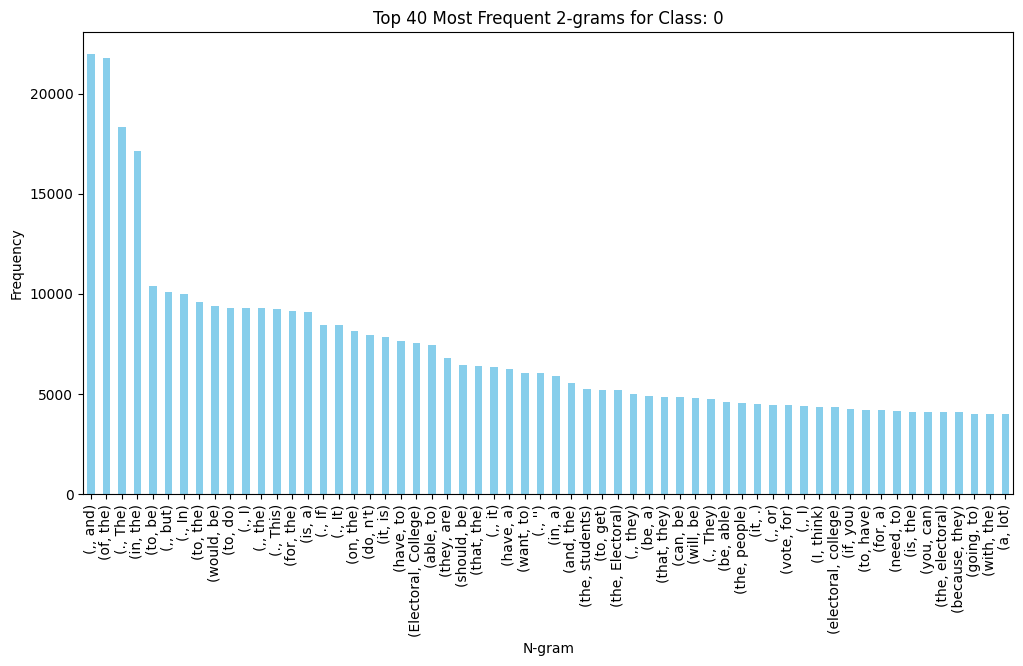

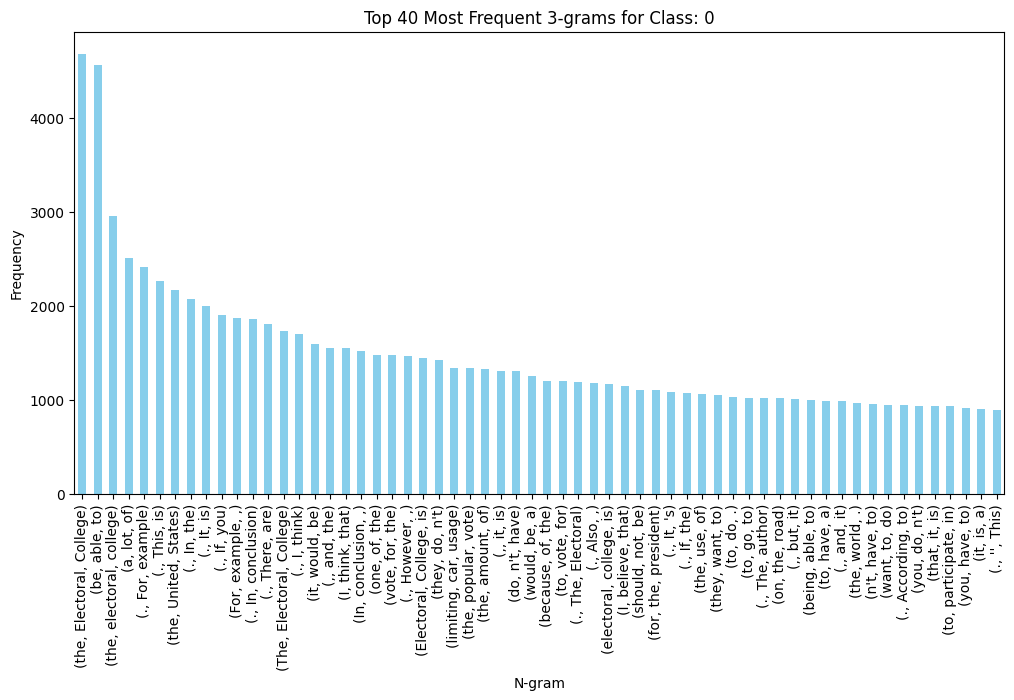

In [168]:
for label in df['generated'].unique():
    subset_df = df[df['generated'] == label]
    for n in n_grams:
        ngram_freq = [item for sublist in subset_df[f'{n}_grams'] for item in sublist]
        ngram_freq_dist = pd.Series(ngram_freq).value_counts()

       
        plt.figure(figsize=(12, 6))
        ngram_freq_dist.head(60).plot(kind='bar', color='skyblue')
        plt.title(f'Top 60 Most Frequent {n}-grams for Class: {label}')
        plt.xlabel('N-gram')
        plt.ylabel('Frequency')
        plt.show()

# Additional Features (Sentiment Scores)

### Sentiment scores can be used as new features, if they could represent any useful signal for our task

In [169]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
tqdm.pandas(desc="Calculating Sentiment Scores")
df['sentiment_score'] = df['text'].progress_apply(lambda x: sia.polarity_scores(str(x))['compound'])

Calculating Sentiment Scores: 100%|██████████| 22750/22750 [01:49<00:00, 208.33it/s]


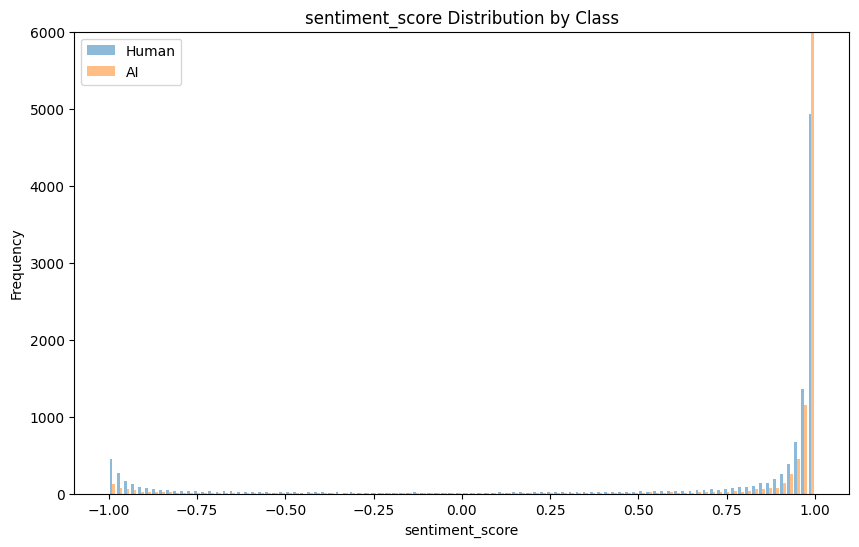

In [170]:
plt.figure(figsize=(10, 6))
plt.hist([df[df['generated'] == 0]['sentiment_score'], df[df['generated'] == 1]['sentiment_score']], bins=100, alpha=0.5, label=['Human', 'AI'])
plt.title('sentiment_score Distribution by Class')
plt.xlabel('sentiment_score')
plt.ylabel('Frequency')
# plt.xlim(right=1,left=0)
plt.ylim(top=6000)
plt.legend()
plt.show()

#### This figure shows that there might be a difference between sentiment scores of AI and Students!

In [171]:
import nltk

### From the above Visualizations, we saw that word count can be a useful feature for our task!

In [172]:
df['word_count'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [173]:
df.sample(3)

,text,generated,tokens,characters,words,unique_words,sentences,1_grams,2_grams,3_grams,sentiment_score,word_count
12965,Title: The Power of Shared Experiences: Learni...,1,"[Title, :, The, Power, of, Shared, Experiences...",2364,442,192,19,"[(Title,), (:,), (The,), (Power,), (of,), (Sha...","[(Title, :), (:, The), (The, Power), (Power, o...","[(Title, :, The), (:, The, Power), (The, Power...",0.9987,442
3817,"Dear State Senator, It has recently come to my...",0,"[Dear, State, Senator, ,, It, has, recently, c...",4141,834,287,29,"[(Dear,), (State,), (Senator,), (,,), (It,), (...","[(Dear, State), (State, Senator), (Senator, ,)...","[(Dear, State, Senator), (State, Senator, ,), ...",0.9966,834
8357,Have you ever played a sport for your school? ...,0,"[Have, you, ever, played, a, sport, for, your,...",4125,805,289,32,"[(Have,), (you,), (ever,), (played,), (a,), (s...","[(Have, you), (you, ever), (ever, played), (pl...","[(Have, you, ever), (you, ever, played), (ever...",-0.9981,805


In [ ]:
!pip install bpe

# Classical Modeling

## I did TF-IDF vectorization on my text!
## Random Forest Classifier was then used as my model with 100 estimators as its parameter.

### It is important to note that TF-IDF can figure out how important a word is to a document in a corpus, so I just used 'text' and didn't care about all the other features for my tokenization to simplify the training. those feature can be used in future works!

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Assuming df is your DataFrame with 'text' and 'generated' columns
X = df['text']
y = df['generated']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Initialize the model (you can choose any other classifier as per your preference)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
predictions = model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, predictions)
print(f"Validation Accuracy: {accuracy}")


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Validation Accuracy: 0.9791208791208791


# I got Validation Accuracy of ~ 0.98

In [179]:
roc_auc = roc_auc_score(y_val, predictions)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9789850102870579


# Also ROC-AUC Score of ~ 0.98

# Neural Network Model

#### importing relavant libraries

In [180]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle

## Preprocessing the data to be trained

In [187]:
# only using 'text' as input
X = df['text']
y = df['generated']

# Encoding the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Tokenize and pad the input text

In [188]:
# Tokenize and pad the input text
max_sequence_length = 100  # can be Adjusted if needed!
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X) # building a vocabulary and assigning unique indices to each word
X_sequences = tokenizer.texts_to_sequences(X) # Converts each text in the dataset (X) into a sequence of
                                              # corresponding word indices based on the learned vocabulary.
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post') 
# the above line Adds padding at the end of each sequence to a maximum length on X_sequences

## Data Split: Stratified K-Fold 

### this is more useful than the simple split where data is not balanced, or concated like here!

In [189]:
# Initialize Stratified K-Fold
num_folds = 5  # Adjust as needed
random_seed = 42  # Adjust as needed
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# Placeholder for model training and evaluation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_padded, y)):
    print(f"Training on Fold {fold + 1}")

    # Split data into training and validation sets
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

Training on Fold 1
Training on Fold 2
Training on Fold 3
Training on Fold 4
Training on Fold 5


## LSTM (Long-Sort Term Memory) Architecture

#### This is a sequential model with an embedding layer, an LSTM layer, and a dense layer for our binary classification. It is compiled with the Adam optimizer, binary cross-entropy loss, and the AUC metric for monitoring the ROC-AUC score during training.

In [198]:
from tensorflow.keras.metrics import AUC

# Define and compile the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(units=64))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='roc_auc')])

## Training

#### this code trains a neural network model for binary classification and validates it on a separate validation set, and evaluates its performance using the ROC-AUC score. 
#### The threshold for converting probabilities to binary classes is set at 0.5!

In [202]:
# Train the model
epochs = 15  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]
roc_auc = roc_auc_score(y_val, y_pred_classes)
print(f"Validation roc_auc for Fold {fold + 1}: {roc_auc}")

Epoch 1/15
569/569 [==============================] - 5s 9ms/step - loss: 5.8065e-04 - roc_auc: 1.0000 - val_loss: 0.1530 - val_roc_auc: 0.9856
Epoch 2/15
569/569 [==============================] - 5s 9ms/step - loss: 3.8730e-04 - roc_auc: 1.0000 - val_loss: 0.1342 - val_roc_auc: 0.9877
Epoch 3/15
569/569 [==============================] - 5s 9ms/step - loss: 2.7953e-04 - roc_auc: 1.0000 - val_loss: 0.1468 - val_roc_auc: 0.9864
Epoch 4/15
569/569 [==============================] - 5s 9ms/step - loss: 2.2711e-04 - roc_auc: 1.0000 - val_loss: 0.1525 - val_roc_auc: 0.9852
Epoch 5/15
569/569 [==============================] - 5s 9ms/step - loss: 1.8690e-04 - roc_auc: 1.0000 - val_loss: 0.1733 - val_roc_auc: 0.9841
Epoch 6/15
569/569 [==============================] - 5s 9ms/step - loss: 1.9908e-04 - roc_auc: 1.0000 - val_loss: 0.1796 - val_roc_auc: 0.9839
Epoch 7/15
569/569 [==============================] - 5s 9ms/step - loss: 1.5357e-04 - roc_auc: 1.0000 - val_loss: 0.1903 - val_roc_auc:

## Validation ROC-AUC ~ 0.98

### Ploting the ROC Curve

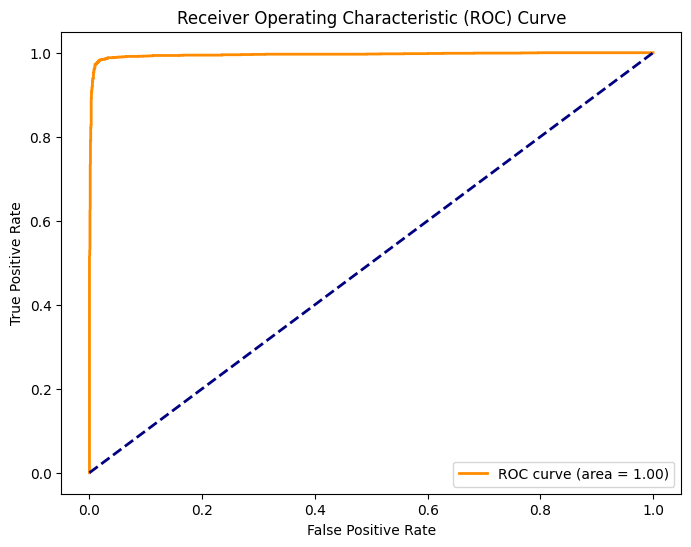

In [200]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
